In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch, HyperParameters
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.engine.hyperparameters import Choice


# Charger le jeu de données
df = pd.read_csv('./data_pre_process.csv', index_col=0)

# Définition du chemin vers les images
path_to_images = '../../../images/image_train/'

# Création des noms de fichier des images
df['Nom image'] = ['image_' + str(imageid) + '_product_' + str(productid) + '.jpg' for imageid, productid in zip(df['imageid'], df['productid'])]

# Conversion de 'prdtypecode' en chaîne de caractère
df['prdtypecode'] = df['prdtypecode'].astype(str)

# Création des liens complets vers les images
df['lien'] = path_to_images + df['prdtypecode']+ '/' + df['Nom image']

display(df.head())
display(df['lien'])

,designation,description,productid,imageid,prdtypecode,lang_designation,lang_description,designation_in_description_ratio,description_complete,lang_description_complete,description_complete_length,Nom image,lien
0,olivia personalisiertes notizbuch seiten punkt...,olivia personalisiertes notizbuch seiten punkt...,3804725264,1263597046,10,de,de,1.0,olivia personalisiertes notizbuch seiten punkt...,de,59,image_1263597046_product_3804725264.jpg,../../../images/image_train/10/image_126359704...
1,journal art marche salon asiatique paris jacqu...,journal art marche salon asiatique paris jacqu...,436067568,1008141237,2280,fr,fr,1.0,journal art marche salon asiatique paris jacqu...,fr,119,image_1008141237_product_436067568.jpg,../../../images/image_train/2280/image_1008141...
2,grand stylet ergonomique bleu gamepad nintendo...,pilot style touch pen marque speedlink stylet ...,201115110,938777978,50,en,fr,1.0,grand stylet ergonomique bleu gamepad nintendo...,fr,567,image_938777978_product_201115110.jpg,../../../images/image_train/50/image_938777978...
3,peluche donald europe disneyland marionnette d...,peluche donald europe disneyland marionnette d...,50418756,457047496,1280,fr,fr,1.0,peluche donald europe disneyland marionnette d...,fr,50,image_457047496_product_50418756.jpg,../../../images/image_train/1280/image_4570474...
4,guerre tuques,luc idÃ©es grandeur veut organiser jeu guerre ...,278535884,1077757786,2705,fr,fr,0.5,guerre tuques luc idÃ©es grandeur veut organis...,fr,118,image_1077757786_product_278535884.jpg,../../../images/image_train/2705/image_1077757...


0        ../../../images/image_train/10/image_126359704...
1        ../../../images/image_train/2280/image_1008141...
2        ../../../images/image_train/50/image_938777978...
3        ../../../images/image_train/1280/image_4570474...
4        ../../../images/image_train/2705/image_1077757...
                               ...                        
84911    ../../../images/image_train/40/image_941495734...
84912    ../../../images/image_train/2583/image_1188462...
84913    ../../../images/image_train/2280/image_1009325...
84914    ../../../images/image_train/1560/image_1267353...
84915    ../../../images/image_train/2522/image_6846712...
Name: lien, Length: 78822, dtype: object

In [2]:
'''
# Configuration de ImageDataGenerator pour le prétraitement et l'augmentation des données
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% des données pour la validation
)

# Générateur pour l'ensemble d'entraînement et de validation
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,  # Aucun répertoire car les chemins sont complets dans `df['lien']`
    x_col='lien',  # La colonne contenant les chemins complets des images
    y_col='prdtypecode',  # La colonne contenant les étiquettes
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='lien',
    y_col='prdtypecode',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Fonction pour construire le modèle avec VGG16
def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(27, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Configuration et démarrage de la recherche d'hyperparamètres
tuner = RandomSearch(
    build_model,  # Pass the function reference without arguments
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory="C:/Users/matth/OneDrive/Documents/GitHub/Rakuten_project/keras_tuner_dir",
    project_name='keras_tuner_demo'
)

tuner.search(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)

# Récupération du meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(validation_generator)
'''

'\n# Configuration de ImageDataGenerator pour le prétraitement et l\'augmentation des données\ndatagen = ImageDataGenerator(\n    rescale=1./255,\n    validation_split=0.2  # 20% des données pour la validation\n)\n\n# Générateur pour l\'ensemble d\'entraînement et de validation\ntrain_generator = datagen.flow_from_dataframe(\n    dataframe=df,\n    directory=None,  # Aucun répertoire car les chemins sont complets dans `df[\'lien\']`\n    x_col=\'lien\',  # La colonne contenant les chemins complets des images\n    y_col=\'prdtypecode\',  # La colonne contenant les étiquettes\n    target_size=(64, 64),\n    batch_size=32,\n    class_mode=\'categorical\',\n    subset=\'training\'\n)\n\nvalidation_generator = datagen.flow_from_dataframe(\n    dataframe=df,\n    directory=None,\n    x_col=\'lien\',\n    y_col=\'prdtypecode\',\n    target_size=(64, 64),\n    batch_size=32,\n    class_mode=\'categorical\',\n    subset=\'validation\'\n)\n\n# Fonction pour construire le modèle avec VGG16\ndef b

In [3]:
# Configuration de ImageDataGenerator pour le prétraitement et l'augmentation des données
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% des données pour la validation
)

# Générateur pour l'ensemble d'entraînement et de validation
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,  # Aucun répertoire car les chemins sont complets dans `df['lien']`
    x_col='lien',  # La colonne contenant les chemins complets des images
    y_col='prdtypecode',  # La colonne contenant les étiquettes
    target_size=(224, 224),  # La taille d'entrée pour VGG16 doit être (224, 224)
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='lien',
    y_col='prdtypecode',
    target_size=(224, 224),  # Même taille d'entrée pour la validation
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Fonction pour construire le modèle avec VGG16
def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Mise à jour de la taille d'entrée
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Ajout d'une couche dense dont le nombre d'unités est optimisé par Keras Tuner
    x = Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(x)
    predictions = Dense(df['prdtypecode'].nunique(), activation='softmax')(x)  # Le nombre de classes
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze des couches du modèle de base pour le transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Configuration et démarrage de la recherche d'hyperparamètres
tuner = RandomSearch(
    build_model,  # Pass the function reference without arguments
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory="./keras_tuner_dir",
    project_name='keras_tuner_demo'
)

# Recherche avec Keras Tuner
tuner.search(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[EarlyStopping('val_loss', patience=3)]
)

# Récupération du meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

# Évaluation du meilleur modèle
best_model.evaluate(validation_generator)


In [ ]:
# Récupération du meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

# Évaluation du meilleur modèle
best_model.evaluate(validation_generator)

In [3]:
from keras_tuner import RandomSearch
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Charger le jeu de données
df = pd.read_csv('./data_pre_process.csv', index_col=0)

# Définition du chemin vers les images
path_to_images = '../../../images/image_train/'

# Création des noms de fichier des images
df['Nom image'] = ['image_' + str(imageid) + '_product_' + str(productid) + '.jpg' for imageid, productid in zip(df['imageid'], df['productid'])]

# Conversion de 'prdtypecode' en chaîne de caractère
df['prdtypecode'] = df['prdtypecode'].astype(str)

# Création des liens complets vers les images
df['lien'] = path_to_images + df['prdtypecode']+ '/' + df['Nom image']

# Fonction pour construire le modèle avec VGG16
def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Mise à jour de la taille d'entrée
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Ajout d'une couche dense dont le nombre d'unités est optimisé par Keras Tuner
    x = Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(x)
    predictions = Dense(df['prdtypecode'].nunique(), activation='softmax')(x)  # Le nombre de classes
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze des couches du modèle de base pour le transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Configuration de ImageDataGenerator pour le prétraitement et l'augmentation des données
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% des données pour la validation
)

# Générateur pour l'ensemble d'entraînement et de validation
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,  # Aucun répertoire car les chemins sont complets dans `df['lien']`
    x_col='lien',  # La colonne contenant les chemins complets des images
    y_col='prdtypecode',  # La colonne contenant les étiquettes
    target_size=(224, 224),  # La taille d'entrée pour VGG16 doit être (224, 224)
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='lien',
    y_col='prdtypecode',
    target_size=(224, 224),  # Même taille d'entrée pour la validation
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory="./keras_tuner_dir",
    project_name='keras_tuner_demo'
)

Found 63058 validated image filenames belonging to 27 classes.
Found 15764 validated image filenames belonging to 27 classes.
Reloading Tuner from C:/Users/matth/OneDrive/Documents/GitHub/Rakuten_project/keras_tuner_dir\keras_tuner_demo\tuner0.json


In [4]:
best_model = tuner.get_best_models(num_models=1)[0]

In [5]:
# Évaluation sur l'ensemble de validation
validation_loss, validation_accuracy = best_model.evaluate(validation_generator)
print(f'Validation Accuracy: {validation_accuracy*100:.2f}%')



493/493 [==============================] - 986s 2s/step - loss: 1.5811 - accuracy: 0.5344
Validation Accuracy: 53.44%


In [6]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Prédire les étiquettes pour l'ensemble de validation
predictions = best_model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Obtenir les vraies étiquettes de l'ensemble de validation
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Calculer le score F1
f1Score = f1_score(true_classes, predicted_classes, average='weighted') # 'micro', 'macro', 'weighted' selon le contexte
print(f'F1 Score: {f1Score}')

# Rapport de classification complet
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

493/493 [==============================] - 955s 2s/step
F1 Score: 0.05534622825904909
              precision    recall  f1-score   support

          10       0.03      0.03      0.03       592
        1140       0.05      0.04      0.04       520
        1160       0.04      0.05      0.05       751
        1180       0.00      0.00      0.00       145
        1280       0.07      0.07      0.07       913
        1281       0.05      0.02      0.03       387
        1300       0.07      0.09      0.08       952
        1301       0.03      0.01      0.01       129
        1302       0.05      0.03      0.03       473
        1320       0.03      0.03      0.03       616
        1560       0.07      0.07      0.07       975
        1920       0.03      0.03      0.03       739
        1940       0.00      0.00      0.00       140
        2060       0.05      0.06      0.06       955
        2220       0.00      0.00      0.00       164
        2280       0.05      0.06      0.06      

Fichier sélectionné : C:/Users/matth/OneDrive/Documents/GitHub/Rakuten_project/Data/processed/image_train/1320/image_885728370_product_131504512.jpg


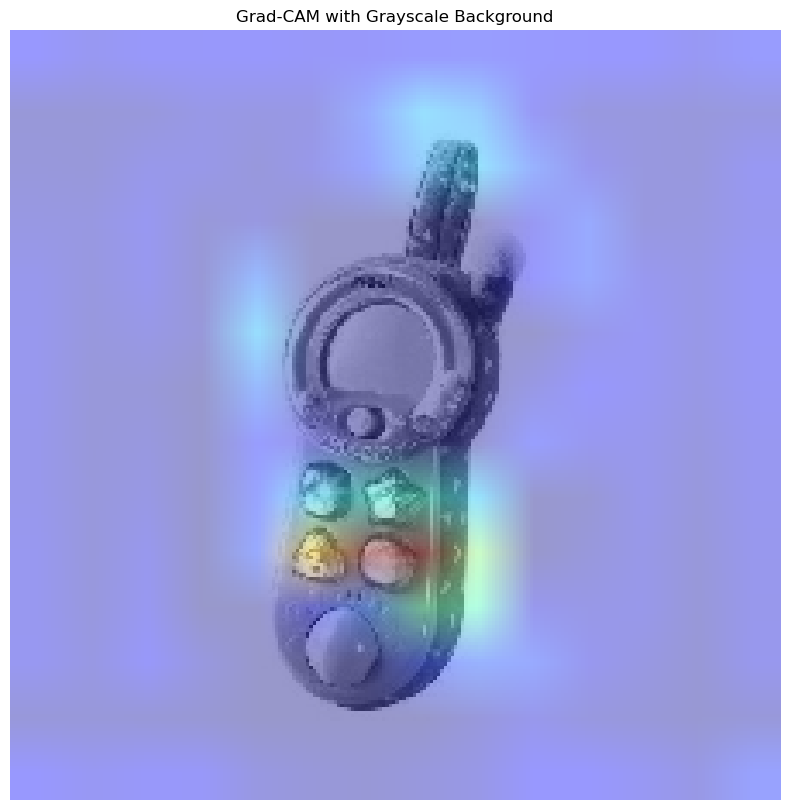

In [22]:
import tkinter as tk
from tkinter import filedialog
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.cm as cm
from matplotlib import pyplot as plt

# Fonction pour générer le Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Initialiser Tkinter et cacher la fenêtre principale
root = tk.Tk()
root.withdraw()

# Ouvrir une boîte de dialogue pour sélectionner une image
file_path = filedialog.askopenfilename()

if not file_path:
    print("Aucun fichier sélectionné.")
else:
    print(f"Fichier sélectionné : {file_path}")

    # Charger le modèle VGG16 pré-entraîné
    model = VGG16(weights='imagenet')
    last_conv_layer_name = 'block5_conv3'

    # Prétraiter l'image
    img = load_img(file_path, target_size=(224, 224))
    img_array = preprocess_input(np.expand_dims(img_to_array(img), axis=0))

    # Générer le Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Appliquer la colormap (en utilisant le heatmap directement pour la transparence)
    jet_heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)

    # Redimensionner le heatmap pour correspondre à la taille de l'image originale
    jet_heatmap = tf.image.resize(jet_heatmap, (224, 224))
    jet_heatmap = jet_heatmap.numpy()

    # Convertir l'image originale en nuances de gris
    gray_img = np.dot(img_to_array(img)[..., :3], [0.2989, 0.5870, 0.1140])
    gray_img = np.repeat(gray_img[..., np.newaxis], 3, axis=2)

    # Superposer le heatmap coloré sur l'image en nuances de gris
    superimposed_img = jet_heatmap * 0.4 + gray_img * 0.6
    superimposed_img = np.uint8(superimposed_img)

    # Afficher l'image originale et le heatmap
    plt.figure(figsize=(20, 10))
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM with Grayscale Background')
    plt.axis('off')
    plt.show()

In [25]:
# Supposons que 'model' est votre modèle Keras entraîné
model.save('best_model.h5')

In [26]:
from tensorflow.keras.models import load_model

# Charger le modèle
model = load_model('best_model.h5')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 69: invalid continuation byte

In [29]:
model.save('best_model.keras')


In [33]:
print(df['prdtypecode'].dtypes)

int64


In [1]:
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Charger le DataFrame
df = pd.read_csv('./data_pre_process.csv', index_col=0)

# Mise à jour du DataFrame avec les chemins complets
path_to_images = '../../../image_train/'
df['Nom image'] = ['image_' + str(imageid) + '_product_' + str(productid) + '.jpg' for imageid, productid in zip(df['imageid'], df['productid'])]
df['lien'] = path_to_images + df['prdtypecode'].astype(str) + '/' + df['Nom image']
df['prdtypecode'] = df['prdtypecode'].astype(str)

# Charger le modèle keras
model = load_model('best_model.keras')

# Adapter le modèle à un nouveau nombre de classes (27 ici)
# Remplacer la dernière couche par une nouvelle
x = model.layers[-2].output  # Prendre l'avant-dernière couche du modèle chargé
x = Dense(1024, activation='relu')(x)  # Ajouter une nouvelle couche Dense
predictions = Dense(27, activation='softmax')(x)  # Ajouter la couche de sortie pour 27 classes
model = Model(inputs=model.input, outputs=predictions)

# Compiler le modèle adapté
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Préparation des données d'entraînement et de validation avec ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_dataframe(dataframe=df,
                                              directory=None,
                                              x_col='lien',
                                              y_col='prdtypecode',
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='training')

validation_generator = datagen.flow_from_dataframe(dataframe=df,
                                                   directory=None,
                                                   x_col='lien',
                                                   y_col='prdtypecode',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   subset='validation')

# Réentraîner le modèle
model.fit(train_generator,
          validation_data=validation_generator,
          epochs=5)  # Ajustez le nombre d'époques selon vos besoins

# Sauvegarder le modèle réentraîné en .h5
model.save('retrained_best_model.h5')




Found 63058 validated image filenames belonging to 27 classes.
Found 15764 validated image filenames belonging to 27 classes.
Epoch 1/5


1666/1971 [========================>.....] - ETA: 1:21:03 - loss: 2.8565 - accuracy: 0.1991